# Text Summarization With Encoder-Decoder Sequence-to-Sequence Models (Seq2Seq)

For a more detailed breakdown of the code, check out [Part 1](https://blog.paperspace.com/introduction-to-seq2seq-models/) of the seq2seq series covering theory and data preparation, then [Part 2](https://blog.paperspace.com/introduction-to-seq2seq-models/) which covers training and inference in more detail.

In [ ]:
# Download the data
!wget https://s3.amazonaws.com/ps.public.resources/ml-showcase/news_summary.csv
!wget https://s3.amazonaws.com/ps.public.resources/ml-showcase/news_summary_more.csv

In [ ]:
# Install necessary libraries
# Note: You may need to restart your kernel!
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm
!pip install pandas
!pip3 install sklearn

In [1]:
# Download necessary language package in spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 1.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import pandas as pd

data1 = pd.read_csv('news_summary.csv', encoding='iso-8859-1')
data2 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
df1 = data2.iloc[:, 0:2].copy()
df2 = data1.iloc[:, 0:6].copy()

# Concatenate dataframe 1 and dataframe 2 to create a more reliable model
df2['text'] = df2['author'].str.cat(df2['date'].str.cat(df2['read_more'].str.cat(df2['text'].str.cat(df2['ctext'], sep = " "), sep = " "),sep = " "), sep = " ")

df = pd.DataFrame()
df['text'] = pd.concat([df1['text'], df2['text']], ignore_index=True)
df['summary'] = pd.concat([df1['headlines'],df2['headlines']], ignore_index = True)

In [4]:
df.head(2)

,text,summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...


In [5]:
import re

# Remove non-alphabetic characters (Data Cleaning)
def text_strip(column):
    
    for row in column:        
        row = re.sub("(\\t)", ' ', str(row)).lower() 
        row = re.sub("(\\r)", ' ', str(row)).lower() 
        row = re.sub("(\\n)", ' ', str(row)).lower()
        
        # Remove _ if it occurs more than one time consecutively
        row = re.sub("(__+)", ' ', str(row)).lower()   
        
        # Remove - if it occurs more than one time consecutively
        row = re.sub("(--+)", ' ', str(row)).lower()
        
        # Remove ~ if it occurs more than one time consecutively
        row = re.sub("(~~+)", ' ', str(row)).lower()   
        
        # Remove + if it occurs more than one time consecutively
        row = re.sub("(\+\++)", ' ', str(row)).lower()   
        
        # Remove . if it occurs more than one time consecutively
        row = re.sub("(\.\.+)", ' ', str(row)).lower()   
        
        # Remove the characters - <>()|&©ø"',;?~*!
        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() 
        
        # Remove mailto:
        row = re.sub("(mailto:)", ' ', str(row)).lower() 
        
        # Remove \x9* in text
        row = re.sub(r"(\\x9\d)", ' ', str(row)).lower() 
        
        # Replace INC nums to INC_NUM
        row = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() 
        
        # Replace CM# and CHG# to CM_NUM
        row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() 
        
        # Remove punctuations at the end of a word 
        row = re.sub("(\.\s+)", ' ', str(row)).lower() 
        row = re.sub("(\-\s+)", ' ', str(row)).lower() 
        row = re.sub("(\:\s+)", ' ', str(row)).lower() 
                
        # Replace any url to only the domain name
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass 
        
        # Remove multiple spaces
        row = re.sub("(\s+)",' ',str(row)).lower() 
        
        # Remove the single character hanging between any two spaces
        row = re.sub("(\s+.\s+)", ' ', str(row)).lower() 
        
        yield row

In [6]:
pretext = text_strip(df['text'])
presum = text_strip(df['summary'])

In [7]:
import spacy
from time import time

t = time()

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) 

# Process texts
text = [str(doc) for doc in nlp.pipe(pretext, batch_size=3000, n_process=-1)]

print('Processing time: {} mins'.format(round((time() - t) / 60, 2)))

Processing time: 9.7 mins


In [8]:
t = time()

# Process summaries
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(presum, batch_size=3000, n_process=-1)]

print('Processing time: {} mins'.format(round((time() - t) / 60, 2)))

Processing time: 1.41 mins


In [9]:
text[0]

'saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad 360-degree career support helped him transition to data scientist at tech mahindra with 90% salary hike upgrad online power learning has powered lakh+ careers.'

In [10]:
summary[0]

'_START_ upgrad learner switches to career in ml al with 90% salary hike _END_'

In [12]:
df['cleaned_text'] = pd.Series(text)
df['cleaned_summary'] = pd.Series(summary)

In [15]:
# Count the length of every sentence in text and summary
text_count = []
summary_count = []

for sent in df['cleaned_text']:
    text_count.append(len(sent.split()))
    
for sent in df['cleaned_summary']:
    summary_count.append(len(sent.split()))

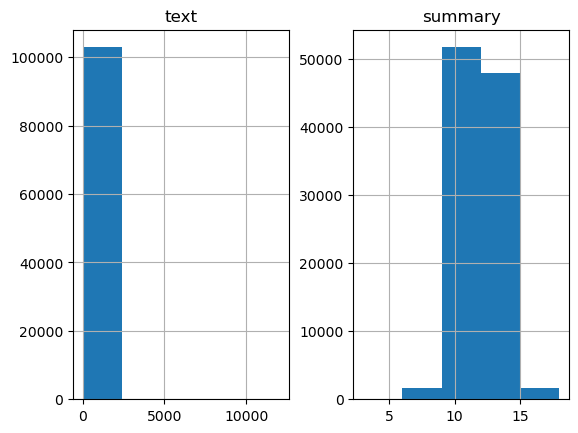

In [16]:
graph_df = pd.DataFrame() 

graph_df['text'] = text_count
graph_df['summary'] = summary_count

# Create histogram using matplotlib
import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [20]:
# Check how much % of text have 0-100 words
cnt = 0
for i in df['cleaned_text']:
    if len(i.split()) <= 100:
        cnt = cnt + 1
print(cnt / len(df['cleaned_text']))

0.9578389933440218


In [21]:
'''
    Create model with following maximum sequence length.
    - Maximum text length : 100 words
    - Maximum summary length : 15 words
'''

max_text_len = 100
max_summary_len = 15

In [22]:
# Select the Summaries and Text which fall below max length 
import numpy as np

cleaned_text = np.array(df['cleaned_text'])
cleaned_summary= np.array(df['cleaned_summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre = pd.DataFrame({'text': short_text,'summary': short_summary})

In [26]:
count_nan = 0

for i in range(len(post_pre)):
    if post_pre['text'][i] == 'nan':
        count_nan += 1

print(count_nan)

118


In [30]:
nan_index = post_pre.loc[post_pre['text'] == 'nan'].index

clear_postpre = post_pre.drop(nan_index).reset_index()
clear_postpre

,index,text,summary
0,0,saurav kant an alumnus of upgrad and iiit-b pg...,_START_ upgrad learner switches to career in m...
1,1,kunal shah credit card bill payment platform c...,_START_ delhi techie wins free food from swigg...
2,2,new zealand defeated india by wickets in the f...,_START_ new zealand end rohit sharma-led india...
3,3,with aegon life iterm insurance plan customers...,_START_ aegon life iterm insurance plan helps ...
4,4,speaking about the sexual harassment allegatio...,_START_ have known hirani for yrs what if meto...
...,...,...,...
98225,98324,chhavi tyagi 11 apr 2017 tuesday indiatoday.in...,_START_ arrest warrant issued against kejriwal...
98226,98337,akshita jain 08 mar 2017 wednesday indiatoday....,_START_ india offers to give up veto power tem...
98227,98339,tarun khanna 07 mar 2017 tuesday indiatoday.in...,_START_ indian fisherman shot dead by sri lank...
98228,98342,abhishek bansal 03 mar 2017 friday indiatoday....,_START_ bombay high court asks govt to take ca...


In [31]:
# Add sostok and eostok at the start and end of the summary
clear_postpre['summary'] = clear_postpre['summary'].apply(lambda x: 'sostok ' + x + ' eostok')

In [32]:
clear_postpre.head(2)

,index,text,summary
0,0,saurav kant an alumnus of upgrad and iiit-b pg...,sostok _START_ upgrad learner switches to care...
1,1,kunal shah credit card bill payment platform c...,sostok _START_ delhi techie wins free food fro...


In [33]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(np.array(clear_postpre['text']),np.array(clear_postpre['summary']), test_size=0.1, random_state=0, shuffle=True)

In [34]:
# Tokenize the text to get the vocab count 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare a tokenizer on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [35]:
thresh = 6

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ",(cnt / tot_cnt) * 100)

% of rare words in vocabulary:  65.99717400080742


In [36]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 26953


In [37]:
# Prepare a tokenizer on testing data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [38]:
thresh = 6

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

% of rare words in vocabulary: 66.35280441732054


In [39]:
# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 11579


In [40]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []

for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [41]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

In [61]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

latent_dim = 300
embedding_dim = 200

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb =  Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# Encoder LSTM 2
# encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
# encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output1)

# Set up the decoder, using `encoder_states` as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 100, 200)     5390600     ['input_7[0][0]']                
                                                                                                  
 input_8 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 lstm_11 (LSTM)                 [(None, 100, 300),   601200      ['embedding_6[0][0]']            
                                 (None, 300),                                               

In [62]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [63]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [65]:
# Note: this will take a while. Run as many epochs as needed.
history = model.fit([x_tr, y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:], epochs=50, callbacks=[es], batch_size=256, validation_data=([x_val, y_val[:, :-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]))

Epoch 1/50
346/346 [==============================] - 1162s 3s/step - loss: 5.1692 - val_loss: 4.8635
Epoch 2/50
346/346 [==============================] - 1269s 4s/step - loss: 4.8040 - val_loss: 4.6146
Epoch 3/50
346/346 [==============================] - 1188s 3s/step - loss: 4.5136 - val_loss: 4.3288
Epoch 4/50
346/346 [==============================] - 1183s 3s/step - loss: 4.2428 - val_loss: 4.1373
Epoch 5/50
346/346 [==============================] - 1184s 3s/step - loss: 4.0411 - val_loss: 3.9943
Epoch 6/50
346/346 [==============================] - 1180s 3s/step - loss: 3.8775 - val_loss: 3.8588
Epoch 7/50
346/346 [==============================] - 1186s 3s/step - loss: 3.7394 - val_loss: 3.7572
Epoch 8/50
346/346 [==============================] - 1185s 3s/step - loss: 3.6168 - val_loss: 3.6763
Epoch 9/50
346/346 [==============================] - 1139s 3s/step - loss: 3.5078 - val_loss: 3.6058
Epoch 10/50
346/346 [==============================] - 1143s 3s/step - loss: 3.412

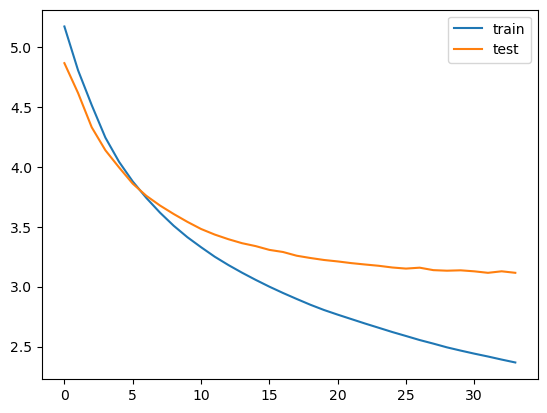

In [66]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [67]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [68]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs) 

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [72]:
def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq, verbose = None)
    
    # Generate empty target sequence of length 1
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c], verbose = None)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token != 'eostok'):
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [73]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if ((i != 0 and i != target_word_index['sostok']) and i!= target_word_index['eostok']):
            newString = newString + reverse_target_word_index[i] + ' '
            
    return newString

# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '
            
    return newString

In [81]:
for i in range(100,150):
    print("Review:", seq2text(x_tr[i]))
    print("Original summary:", seq2summary(y_tr[i]))
    print("Predicted summary:", decode_sequence(x_tr[i].reshape(1, max_text_len)))
    print("\n")

Review: nepal has rejected india offer to jointly the height of mount everest saying they will carry out the exercise on their own nepal will however seek help from india and china for getting crucial data for the exercise the director general of nepal survey department said nepal reportedly declined since the peak falls on its border with china 
Original summary: start nepal rejects india offer to jointly mt everest end 
Predicted summary:  start nepal rejects india offer to return to nepal war end


Review: uk top executives pay declined by 19 as companies trimmed the amount bosses could earn from bonuses salaries fell to ãâ£3 5 million ã¢ââ¹28 9 crore in 2016 from ãâ£4 3 million ã¢ââ¹35 5 crore year ago deloitte survey revealed another report earlier found an average employee would have to work for 160 years to earn 100 ceo annual pay 
Original summary: start pay of uk top executives declines by 19 end 
Predicted summary:  start uk top uk top executives pay for 2017 18 billion e

Predicted summary:  start actor arrested for raping actor in mumbai end


Review: the supreme court has directed real estate firm unitech to deposit ã¢ââ¹750 crore by december end for giving refunds to the homebuyers sc said it will consider granting bail to unitech md sanjay chandra only after the money is deposited the court permitted video conferencing facility to chandra to be able to sell his properties and assets to generate the money 
Original summary: start sc asks unitech to deposit crore by december end end 
Predicted summary:  start sc orders unitech to refund unitech for unitech end


Review: relations between india and the us have grown from and mutual suspicion to friendship and partnership us ambassador to the un nikki haley said on thursday haley added that indian americans are the most educated and highly philanthropic minority in the us despite being nuclear power india is respected globally as it is responsible democracy she further said 
Original summary: start ind

Predicted summary:  start pm modi not to be congress leader on rahul gandhi end


Review: a ludhiana court has issued fresh non bailable warrant against actress rakhi sawant for her alleged objectionable remarks against sage valmiki the complaint was filed against rakhi last year for allegedly hurting religious sentiments of the valmiki community after warrant was issued against her in april 2017 rakhi claimed she never spoke against sage valmiki and issued an apology n 
Original summary: start fresh non bailable warrant against rakhi for remarks end 
Predicted summary:  start non bailable warrant issued against rakhi sawant end


Review: asking trinamool congress leaders to stop throwing mud at his office west bengal governor kn tripathi has said they should instead go to the washroom and wash the dirt off their faces this comes after the tmc accused tripathi of bypassing the state government when he sent letter to senior officer asking him to call an administrative meeting 
Original 

In [75]:
model.save('summarizer_model_v1.h5', save_format='h5')

array([[   23,   382, 11135, ...,     0,     0,     0],
       [    1,    79,   528, ...,     0,     0,     0],
       [    1,    46,   318, ...,     0,     0,     0],
       ...,
       [  114,   468,     8, ...,     0,     0,     0],
       [ 1576,   542,   613, ...,     0,     0,     0],
       [  580,  6706,  8509, ...,     0,     0,     0]], dtype=int32)